In [121]:
import os
import numpy as np
import cv2
from src.tools import imgPeak, imgsPeak
from findpeaks import findpeaks
import src.seelib.cv2eff as cve 
import matplotlib.pyplot as plt
from src.loader import Sampler
from src.graph import Graph
from src.solver import graphSolver
from src.loader import poscarLoader

dataset = "../data/middle"
modelname = "unet_tune_v0"
sampler = Sampler(dataset, modelname = modelname)

hup_layer = [10, 11, 12]
making = "st5"

findpeak_img = {
    "HDA3": 10,
    "HDA4": 7,
    "HDA5": 7,
    "HDA6": 6,
    "HDA7": 10,
    "HDA8": 10,
    "ss0": None,
    "exp91": None,
    "pls1": None,
    "pls2": None,
    "pls3": None,
    "pls4": 6,
    "pls5": None,
    "pls6": None,
    "pls7": None,
    "st1": None,
    "st2": None,
    "st3": None,
    "st4": None,
    "st5": None
}

pos_offset = {
    "HDA3": (-15,3),
    "HDA4": (-15,3),
    "HDA5": (-10,3),
    "HDA6": (-10,3),
    "HDA7": (-10,3),
    "HDA8": (-10,3),
    "ss0": (0, 0),
    "exp91": (0, 0),
}

pos_offset = pos_offset[making] if making in pos_offset else (0, 0)
#HDA_5 -10
# HDA_4 -15
# HDA_3 -15

In [122]:
name, imgs, dic = sampler.get(making)
print(name, imgs.shape, dic.keys())
print(dic['real_size'])
print(dic['elem'])
print(dic['scale'])
# print(dic['pos'])
imgs = imgs.squeeze(1).numpy()


st4 torch.Size([5, 1, 564, 564]) dict_keys(['real_size', 'elem', 'scale', 'pos'])
(3.0, 60.0, 60.0)
('O', 'H')
1.0


In [123]:
fp_img = findpeak_img[making]
if fp_img is not None:
    img = imgs[fp_img]
    print(img.shape)

    # fp1 = findpeaks(method='topology', denoise='lee_enhanced',
    #                window=9, limit=40, interpolate=5)

    # fp2 = findpeaks(method='topology', denoise='fastnl',
    #                window=3, limit=10, interpolate=10)

    # fp3 = findpeaks(method='topology', denoise='fastnl',
    #                window=5, limit=40, interpolate=10)

    # fp4 = findpeaks(method='topology', denoise='fastnl',
    #                window=7, limit=40, interpolate=10)

    fp1 = findpeaks(method='topology', denoise='lee_enhanced',
                window=9, limit=40, interpolate=5)

    fp2 = findpeaks(method='topology', denoise='fastnl',
                window=3, limit=10, interpolate=10)

    fp3 = findpeaks(method='topology', denoise='fastnl',
                window=5, limit=40, interpolate=10)

    fp4 = findpeaks(method='topology', denoise='fastnl',
                window=7, limit=40, interpolate=10)

    pos = imgsPeak(img, [fp1, fp2, fp3, fp4], cluster_threshold= 10, inverse=True, border=2, show=True, flip= None) # y, x, c format
    pos = pos[...,(1,0,2)]
    pos[...,0] = pos[...,0] + pos_offset[0]
    pos[...,1] = pos[...,1] + pos_offset[1]
else:
    pos = np.zeros((0, 3))

torch.Size([371, 3])


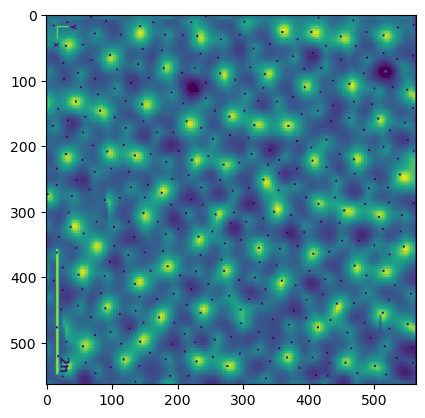

In [124]:
bg = imgs[-3].copy() * 255
# print(dic['pos']['O'][...,1:].numpy()/dic['real_size'][1:], dic['real_size'], bg.shape)
bg = cve.drawPoints(bg, pos[...,:2] / bg.shape, flip = None, size = 5)
print(dic['pos']['O'].shape)
# x y format
bg = cve.drawPoints(bg, dic['pos']['O'][...,1:].numpy() / dic['real_size'][1:], color = (0,0,0), size = 3, flip = None)
plt.imshow(bg)

In [125]:
g = Graph(name, imgs, points_dict= dic['pos'], res = 1, real_size = dic['real_size'])

In [126]:
g.detect_Hup(pos[...,:3])
g.make_edges()

In [127]:
gs = graphSolver(g)
gs.solve()

In [128]:
g.pp_all_nodes()

In [129]:
out_img = g.plotEdges(3, transparency=0.5, text=False, mirror = False)
out_img = g.plotNodes(out_img, reverse= True, mirror = False, text= False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(564, 564)


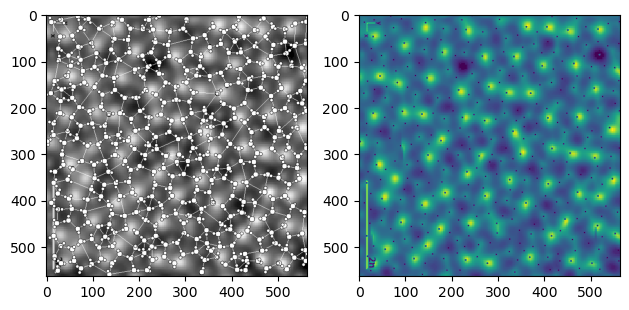

In [130]:
print(imgs[0].shape)
fig, (ax1, ax2) = plt.subplots(1, 2)
cv2.imwrite("test.png", out_img)
ax1.imshow(out_img)
ax2.imshow(bg)
plt.tight_layout()
plt.savefig(f"{dataset}/combine/{modelname}/{making}.png")


In [131]:
s, fix = g.wrtie_data()

In [132]:
with open(f"{dataset}/combine/{modelname}/{making}.data", "w") as f:
    f.write(s)
with open(f"{dataset}/combine/{modelname}/{making}.fix", "w") as f:
    f.write(" ".join(str(i) for i in fix))
g.save(f"{dataset}/combine/{modelname}/{making}_fix.poscar")# 
